<div class="alert alert-info alertinfo" style="margin-top: 0px">
<h1> Natural Language Processing with Disaster Tweets </h1>
part 4 - Model re-evaluation
</div>

<div class="alert-success" style="margin-top: 0px">
<h1> Imports </h1>
</div> 

In [1]:
# Set NLTK data path
import nltk
nltk.data.path.append("C:/Users/ebies/AppData/Roaming/nltk_data")

# standard
import pandas as pd
# import numpy as np
from collections import Counter

# NLP
import re
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize, pos_tag, ne_chunk

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# others
from sklearn.metrics import confusion_matrix
import joblib

### 1. read data set

In [2]:
df = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
edf = pd.read_csv('re_evaluation_set.csv')
english_words = joblib.load('english_words.pkl')
edf.head()

,id,text,processed text,expected,predicted
0,1,Our Deeds are the Reason of this #earthquake M...,reason earthquak may allah forgiv,1,1
1,5,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...,1,1
2,7,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir school,1,0
3,10,#flood #disaster Heavy rain causes flash flood...,flood disast heavi rain caus flash flood stree...,1,1
4,18,#raining #flooding #Florida #TampaBay #Tampa 1...,flood florida day lost count,1,1


In [3]:
def summary_table(df):
    '''
    Creates a summary info table about given data frame
    
    Args:
        df: data frame
        
    Returns:
        summary: info data frame
    '''
    print('There are {} rows in the original data'.format(df.shape[0]))
    summary = pd.DataFrame(df.dtypes, columns = ['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    return summary

In [4]:
summary_table(edf)

There are 6779 rows in the original data


,Name,dtypes,Missing,Uniques
0,id,int64,0,6779
1,text,object,0,6686
2,processed text,object,9,5919
3,expected,int64,0,2
4,predicted,int64,0,2


<div class="alert-success" style="margin-top: 0px">
<h1> Investigating missing processed text </h1>
</div>

In [5]:
edf[edf['processed text']!=edf['processed text']]

,id,text,processed text,expected,predicted
49,363,Are souls punished withåÊannihilation? http://...,NaN,0,0
2225,6394,@Hurricane_Dame ???????? I don't have them the...,NaN,1,0
4584,1178,@jake_blight @WeAlIlKnowA you cunt,NaN,0,0
4890,6429,@Hurricane_Dolce no prob,NaN,1,0
5146,40,Cooool :),NaN,0,0
5192,1191,Stats http://t.co/U7vavyrGv9,NaN,0,0
5563,9697,@Ayshun_Tornado then don't,NaN,0,0
5805,5213,@Truly_Stings Yo Dm me,NaN,1,0
6565,28,What a goooooooaaaaaal!!!!!!,NaN,0,0


In [6]:
'hurricane' in english_words

True

### Conclusion

<div class="alert alert-warning alertwarning" style="margin-top: 0px">
<h4> Most of records with missing 'processed text' have prediction 0 (non-disaster). </h4>
<h4> However we can see that we are excluding important word 'hurricane' because it is preceeded with symbol @.</h4>
<h4> We have to revisit and adjust cleaning function to make sure we fix this problem. </h4>
</div>

### proposed fix

In [7]:
# previous cleaning function
def remove_emails(text):
    text = re.sub(r'\S+@\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'(^|\s)@\w+', '', text)
    return text.strip()

# proposed cleaning function
def remove_emails_1(text):
    text = re.sub(r'\S+@\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\b@\w+', '', text)    
    return text.strip()

text = "@Hurricane_Dolce no prob, email@example.com"
old_text = remove_emails(text)
new_text = remove_emails_1(text)
print(old_text)
print(new_text)

no prob,
@Hurricane_Dolce no prob,


<div class="alert-success" style="margin-top: 0px">
<h1> Investigating most common words found in missclassified records </h1>
</div> 

In [8]:
edf.fillna('', inplace=True)

# top words for false positives and false negatives
labels = ['fp', 'fn', 'tp', 'tn']
edf['correct'] = edf['predicted'] == edf['expected']

def preprocess(text):
    tokens = word_tokenize(text)
    return tokens

result_list = []

for label in labels:
    condition1 = True if label[0] == 't' else False
    condition2 = 1 if label[1] == 'p' else 0
    subset_df = edf[(edf['correct'] == condition1) & (edf['predicted'] == condition2)]
    text = ' '.join(subset_df['processed text'])
    tokens = word_tokenize(text)
    words = [word for x in tokens for word in preprocess(x)]
    top_words = Counter(words).most_common(15)
    result_list.append((f"{label}_top_words", top_words))

# Unpack the results
for label, value in result_list:
    globals()[label] = value

print("Top False Positives Words:", fp_top_words)
print('----------------------------------------')
print("Top False Negatives Words:", fn_top_words)  

Top False Positives Words: [('plan', 16), ('via', 15), ('fire', 13), ('disast', 11), ('hijack', 11), ('emerg', 11), ('nation', 11), ('bomb', 9), ('amp', 9), ('news', 9), ('land', 9), ('nuclear', 9), ('like', 9), ('sinkhol', 9), ('islam', 9)]
----------------------------------------
Top False Negatives Words: [('like', 62), ('amp', 57), ('get', 45), ('burn', 39), ('fire', 38), ('look', 31), ('build', 31), ('one', 28), ('back', 24), ('time', 22), ('peopl', 21), ('watch', 21), ('day', 21), ('storm', 20), ('riot', 20)]


In [9]:
# top words for true positives and true negatives
print("Top True Positives Words:", tp_top_words)
print('----------------------------------------')
print("Top True Negatives Words:", tn_top_words)

Top True Positives Words: [('fire', 199), ('bomb', 162), ('kill', 134), ('news', 122), ('suicid', 102), ('via', 101), ('disast', 97), ('california', 97), ('flood', 95), ('train', 94), ('famili', 94), ('home', 89), ('hiroshima', 87), ('attack', 85), ('polic', 85)]
----------------------------------------
Top True Negatives Words: [('like', 260), ('get', 191), ('amp', 176), ('new', 151), ('one', 125), ('love', 114), ('bodi', 108), ('bag', 104), ('video', 92), ('want', 90), ('day', 90), ('scream', 90), ('would', 87), ('see', 85), ('make', 85)]


In [10]:
# example of how we could 'zoom in' to see which word combinations are contributing the most into missclassification

In [11]:
evaluation_word = 'like'

In [12]:
def show_word_analysis(evaluation_word):
    highlighted_edf = edf[edf['processed text'].str.contains(evaluation_word, case=False, na=False)].reset_index()

    # find most significant neighbour words
    correct = highlighted_edf[highlighted_edf['expected']==highlighted_edf['predicted']]
    wrong = highlighted_edf[highlighted_edf['expected']!=highlighted_edf['predicted']]

    correct_tokens = correct['processed text'].str.split()
    correct_word_freq = Counter([word for sublist in correct_tokens for word in sublist])
    correct_df = pd.DataFrame(list(correct_word_freq.items()), columns=['word', 'correct_freq'])

    wrong_tokens = wrong['processed text'].str.split()
    wrong_word_freq = Counter([word for sublist in wrong_tokens for word in sublist])
    wrong_df = pd.DataFrame(list(wrong_word_freq.items()), columns=['word', 'wrong_freq'])

    merged_df = pd.merge(correct_df, wrong_df, on='word', how='inner')
    filtered_df = merged_df[merged_df['correct_freq'] >= 10]
    filtered_df = filtered_df[filtered_df['correct_freq'] >= 3]
    sorted_df = filtered_df.sort_values(by=['correct_freq', 'wrong_freq'], ascending=False)
    neighbour_words = sorted_df.iloc[1:].reset_index(drop=True)
    neighbours = list(neighbour_words['word'])

    # Initialize the columns with zeros
    neighbour_words['tp'] = 0
    neighbour_words['tn'] = 0
    neighbour_words['fp'] = 0
    neighbour_words['fn'] = 0

    # Loop through each neighbor word
    for neighbour_word in neighbour_words['word']:
        temp_correct = correct[correct['processed text'].str.contains(neighbour_word, case=False, na=False)].reset_index()
        tp = temp_correct[temp_correct['predicted'] == 1].shape[0]
        tn = temp_correct[temp_correct['predicted'] == 0].shape[0]

        temp_wrong = wrong[wrong['processed text'].str.contains(neighbour_word, case=False, na=False)].reset_index()
        fp = temp_wrong[temp_wrong['predicted'] == 1].shape[0]
        fn = temp_wrong[temp_wrong['predicted'] == 0].shape[0]

        # Update values in the DataFrame
        neighbour_words.loc[neighbour_words['word'] == neighbour_word, 'tp'] = tp
        neighbour_words.loc[neighbour_words['word'] == neighbour_word, 'tn'] = tn
        neighbour_words.loc[neighbour_words['word'] == neighbour_word, 'fp'] = fp
        neighbour_words.loc[neighbour_words['word'] == neighbour_word, 'fn'] = fn

    neighbour_words_metrics = neighbour_words[['word', 'tp', 'tn', 'fp', 'fn']].set_index('word')

    # Plotting heatmap
    plt.figure(figsize=(6, 3))
    sns.heatmap(neighbour_words_metrics, annot=True, fmt='d', cmap='Reds')
    plt.xlabel('Metrics')
    plt.ylabel('Neighbor Word')
    plt.title(f'classification accuracy for neighbour word combined with "{evaluation_word}"')
    plt.show()
    return neighbours

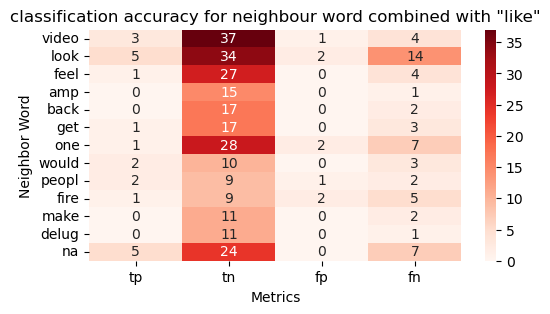

['video',
 'look',
 'feel',
 'amp',
 'back',
 'get',
 'one',
 'would',
 'peopl',
 'fire',
 'make',
 'delug',
 'na']

In [13]:
show_word_analysis('like')

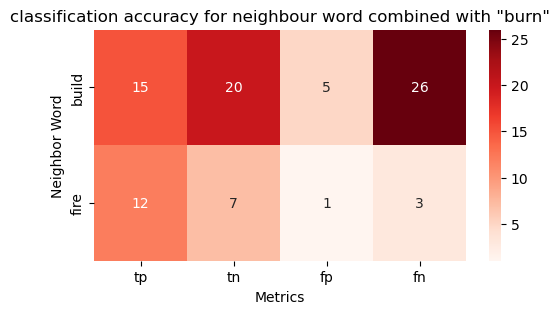

['build', 'fire']

In [14]:
show_word_analysis('burn')

### we can see that word 'like' is over predicting 'non-disaster' when coupled with most of words but especially with 'look'

### word 'burn' is over predicting 'non-disaster' when coupled with word 'build'

### Conclusion

<div class="alert alert-warning alertwarning" style="margin-top: 0px">
<h4> Similar analysis can be done for each word that contribute the most to missclassifications. </h4>
<h4> On example above we found out that word 'like' is mainly biased towards 'non disaster' where coupled with words like 'video', 'look', 'feel' etc. </h4>
<h4> We could adjust our model to lean a bit more towards 'disaster' when seeing those words </h4>
</div>

### In this notebook I have shown logic of 'zooming in' on missclassifications and what could be done to improve the results.
### In the next part we will use pre-trained big language model BERT and we will finetune it to our data set to see the performance 